In [102]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# regex
import re

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from scipy.stats import ks_2samp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

&nbsp;

...

&nbsp;

---

# Analyzing Telomere Length Data from TeloFISH
---

## Mean Telomere Length analyses

### Visualizations

In [82]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
all_patients_df['telo data'] = all_patients_df['telo data'].map(literal_eval)

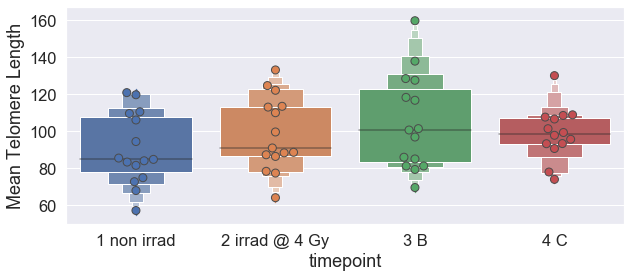

In [39]:
fig = plt.figure(figsize=(10,4))
ax = sns.set(font_scale = 1.5)
ax = sns.boxenplot(x='timepoint',y='telo means', data=all_patients_df,
                  linewidth=1)
ax = sns.swarmplot(x='timepoint',y='telo means', data=all_patients_df, size=8,
                  linewidth=1)

# ax.set_title("Mean Telomere Length (TeloFISH) per timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('timepoint')
plt.savefig('../graphs/paper figures/main figs/all patient Mean telomere length means teloFISH.png', 
            dpi=400)

### Correlations, Linear Regressions

In [4]:
lin_reg_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='telo means')
lin_reg_df = lin_reg_df.drop(13)
lin_reg_df['constant'] = 1

In [5]:
lin_reg_df.corr()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
timepoint,,,,,
1 non irrad,1.000000,0.947341,0.509322,0.401291,NaN
2 irrad @ 4 Gy,0.947341,1.000000,0.620616,0.400194,NaN
3 B,0.509322,0.620616,1.000000,0.534244,NaN
4 C,0.401291,0.400194,0.534244,1.000000,NaN
constant,NaN,NaN,NaN,NaN,NaN


In [6]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'], ['1 non irrad', '2 irrad @ 4 Gy', '3 B']]   
y_name = '4 C'

for x_name in x_names:
    x = lin_reg_df[x_name].values.reshape(-1, len(x_name))
    y = lin_reg_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.1610
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.1649
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy', '3 B'] vs. 4 C:
R2 is 0.3304


In [7]:
# more indepth stats

# target = lin_reg_df['4 C']
# linear_m = sm.OLS(endog=target, exog=lin_reg_df[['1 non irrad', '2 irrad @ 4 Gy', 'constant']], missing='drop')
# results = linear_m.fit()
# results.summary()

## Individual Telomere Length analyses

In [83]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')

### Visualizations

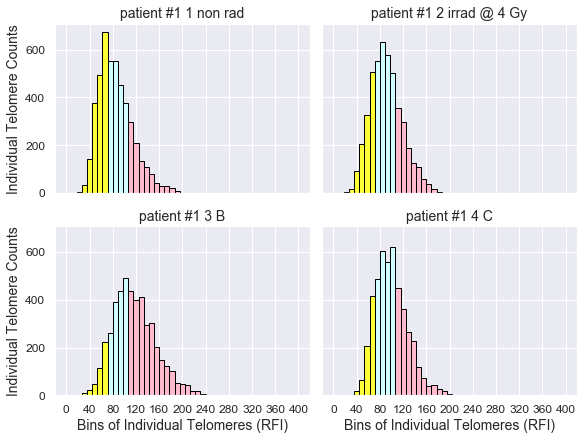

In [108]:
# graphing individual telomeres per individual per timepoint, personal telomere length dynamics as fxn of radiotherapy
patient_ids = list(exploded_telos_all_patients_df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=exploded_telos_all_patients_df, 
                          groupby='patient id', 
                          iterable=[patient_ids[0]],
#                           iterable=patient_ids,
                          n_bins=45,
                          znorm=False)

### Statistics

In [44]:
# one way ANOVA between individual telos .. change to repeated measures ANOVA
trp.telos_scipy_anova_post_hoc_tests(df=exploded_telos_all_patients_df)

ONE WAY ANOVA for telomere length: 0.0
      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  8.297    7.7796  8.8144  True 
 1 non irrad        3 B       14.4682  13.9509 14.9856  True 
 1 non irrad        4 C        8.7314   8.2049  9.258   True 
2 irrad @ 4 Gy      3 B        6.1713   5.6539  6.6886  True 
2 irrad @ 4 Gy      4 C        0.4344  -0.0921  0.961  False 
     3 B            4 C       -5.7368  -6.2633 -5.2103  True 
-------------------------------------------------------------


In [65]:
test_df = exploded_telos_all_patients_df.copy()
for col in test_df.columns:
    test_df.rename({col: col.replace(' ', '_')}, axis=1, inplace=True)
test_df = test_df[test_df['patient_id'] != 13].copy()

In [75]:
test_df.groupby(['timepoint']).agg('mean').reset_index()

,timepoint,patient_id,telo_means,individual_telomeres
0,1 non irrad,8.5,91.324114,91.324114
1,2 irrad @ 4 Gy,8.5,99.232057,99.232057
2,3 B,8.5,106.101398,106.101398
3,4 C,8.5,98.960073,98.960073


In [68]:
from statsmodels.stats.anova import AnovaRM
RM_ANOVA_results =     AnovaRM(test_df, 
                              'individual_telomeres', 
                              'patient_id', 
                              within=['timepoint'], 
                              aggregate_func=np.mean).fit()
print(RM_ANOVA_results)

                 Anova
          Num DF  Den DF F Value Pr > F
---------------------------------------
timepoint 3.0000 39.0000  2.6975 0.0590



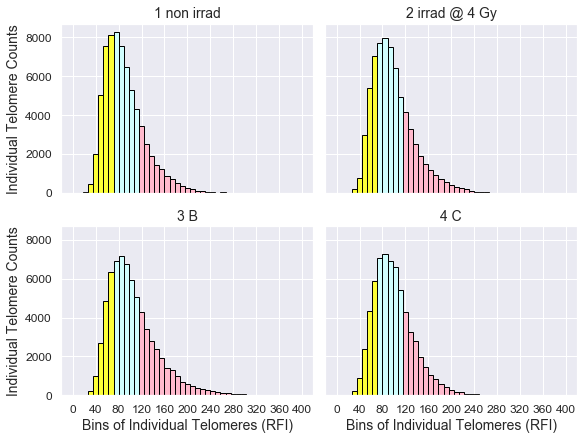

In [89]:
# graphing individual telomeres per timepoint, overall cohort telomere length dynamics as fxn of radiotherapy
patient_ids = list(exploded_telos_all_patients_df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=exploded_telos_all_patients_df, 
                          groupby='timepoint', 
                          n_bins=45,
                          znorm=False)

In [90]:
z_norm = trp.z_norm_individual_telos(exploded_telos_df=exploded_telos_all_patients_df)

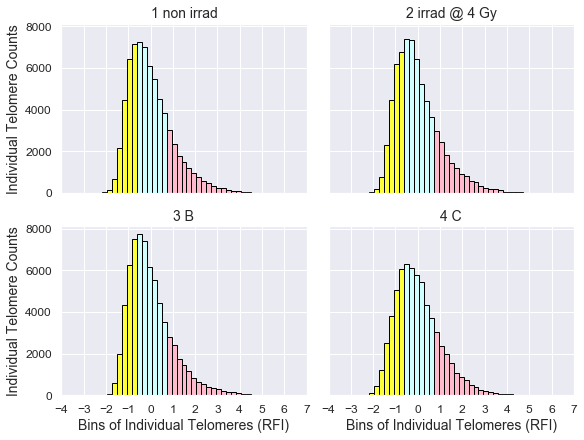

In [91]:
# z-norming distributions of individual telomeres per timepoint to enable statistical analysis between
# shapes of overall cohort telomere length dynamics
time_points = list(z_norm['timepoint'].unique())
trp.histogram_plot_groups(x='z-norm_individual_telos', 
                          data=z_norm, 
                          groupby='timepoint', 
                          n_bins=45, 
                          znorm=True)

In [14]:
# we see a diff. in shape between all timepoints, as well we see a sig diff between irrad @ 4 Gy & 4 C shapes,
# though mean was the same (ANOVA)

test = ks_2samp
test_name = 'Kolmogorov-Smirnov'
timept_pairs, row = trp.eval_make_test_comparisons(df=z_norm, target='z-norm_individual_telos',
                                                   test=test, test_name=test_name,)

Kolmogorov-Smirnov | 1 non irrad vs 2 irrad @ 4 Gy 0.006420699103012419
Kolmogorov-Smirnov | 1 non irrad vs 3 B 1.5359690901005914e-06
Kolmogorov-Smirnov | 1 non irrad vs 4 C 3.472138802175814e-21
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 3 B 6.714318030868901e-08
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 4 C 3.98074303744773e-21
Kolmogorov-Smirnov | 3 B vs 4 C 1.2359717694415352e-35


In [15]:
# iterate for between patients as well? would just be loop using above fxn, passing df per patient

In [16]:
KS_stats_df = pd.DataFrame(row, columns=[test_name, 'timepoint 1', 'timepoint 2', 'p value'])
trp.df_to_png(df=KS_stats_df, path='../graphs/paper figures/supp figs/KS test between overall shapes of individ telo dist.png')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### Feature Engineering Short/Long Individual Telomeres

In [17]:
melted_all_patients_df = pd.melt(
    all_patients_df,
    id_vars = [col for col in all_patients_df.columns if col != 'Q1' and col != 'Q2-3' and col != 'Q4'],
    var_name='relative Q',
    value_name='Q freq counts')

melted_all_patients_df['Q freq counts'] = melted_all_patients_df['Q freq counts'].astype('float64')

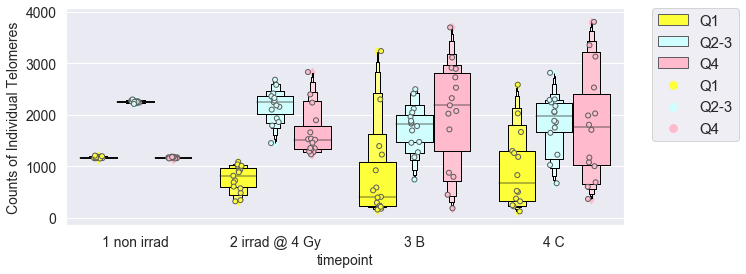

In [107]:
# ax = sns.set(font_scale=1)
fig = plt.figure(figsize=(10,4))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=2, saturation=5, color="black", )
ax = sns.stripplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=1, color="black", dodge=True, )

ax=fig.gca()
# ax.set_title('Changes in Distribution Individual Telos Relative to Pre-Rad Therapy Time point', fontsize=14)
ax.set_xlabel('timepoint', fontsize=14)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=14)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')

# plt.savefig('../graphs/telomere length/examining changes in individual telomere lengths per quartile.png', dpi=400)

# Analyzing Telomere Length Data from qPCR (Aidan/Lynn)
---

In [19]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')

Text(0.5, 0, 'timepoint')

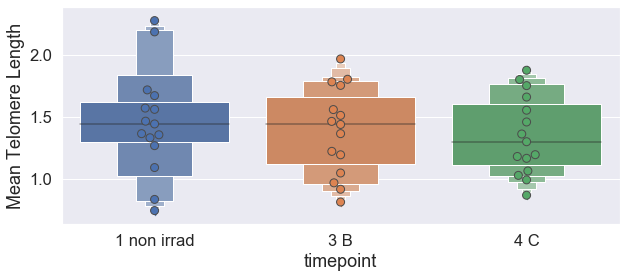

In [43]:
fig = plt.figure(figsize=(10,4))
ax = sns.set(font_scale = 1.5)

ax= sns.boxenplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1)
ax= sns.swarmplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1, size=8)

# ax.set_title("Mean Telomere Length (qPCR) Per Timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('timepoint')
# plt.savefig('../graphs/telomere length/all patient telomere length means qPCR.png', dpi=400)

## Correlations and Linear Regressions 

In [21]:
pivot_qPCR_df = all_qPCR_df.pivot(index='patient id', columns='timepoint', values='telo means qPCR')
pivot_qPCR_df['constant'] = 1
pivot_qPCR_df.corr()

timepoint,1 non irrad,3 B,4 C,constant
timepoint,,,,
1 non irrad,1.000000,0.765298,0.769699,NaN
3 B,0.765298,1.000000,0.880080,NaN
4 C,0.769699,0.880080,1.000000,NaN
constant,NaN,NaN,NaN,NaN


In [22]:
x_names = [['1 non irrad'], ['1 non irrad', '3 B']]
y_name = '4 C'

for x_name in x_names:
    x = pivot_qPCR_df[x_name].values.reshape(-1, len(x_name))
    y = pivot_qPCR_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.5924
Linear regression for ['1 non irrad', '3 B'] vs. 4 C:
R2 is 0.7969


In [23]:
# more indepth stats
# target = pivot_qPCR_df['4 C']
# linear_m = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', 'constant']], missing='drop')
# results = linear_m.fit()
# print(results.summary())

In [24]:
# linear_m2 = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', '3 B', 'constant']], missing='drop')
# results2 = linear_m2.fit()
# print(results2.summary())

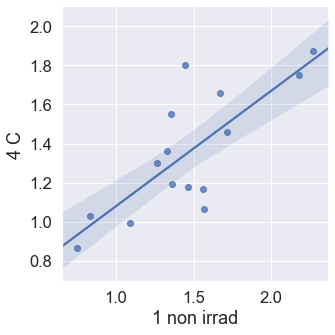

In [25]:
sns.lmplot(x='1 non irrad', y='4 C', data=pivot_qPCR_df, fit_reg=True)

## Statistics 

In [26]:
# conducting one-way ANOVA for mean telomere length
# need change to repeated measures 

df = all_qPCR_df
g_1 = df[df['timepoint'] == '1 non irrad']['telo means qPCR']
g_2 = df[df['timepoint'] == '3 B']['telo means qPCR']
g_3 = df[df['timepoint'] == '4 C']['telo means qPCR']
stats.f_oneway(g_1, g_2, g_3)

F_onewayResult(statistic=0.33940643369655527, pvalue=0.714128148014912)

# Analyzing Chromosome Aberration Data from dGH
---

In [27]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False, adjust_clonality=True))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [28]:
melt_aberrations = pd.melt(cleaned_chr_df, id_vars=['patient id', 'timepoint'],
                           var_name='aberration type', value_name='count per cell')

melt_aberrations['count per cell'] = melt_aberrations['count per cell'].astype('int64')
melt_aberrations['aberration type'] = melt_aberrations['aberration type'].astype('str')

## Visualizing Chromosome Rearrangements

In [29]:
# melt_aberrations_chr_only = melt_aberrations[~melt_aberrations['aberration type'].isin(['# sub-telo SCEs', 'tricentrics',
#                                                                                         '# dicentrics', '# translocations',
#                                                                                         '# sat associations', 'cell number'])].copy()

# ax = sns.set(font_scale=2)
# ax = sns.catplot(y='aberration type', x='count per cell', hue='chromosome', 
#                  col='timepoint', col_wrap=2, 
#                  data=melt_aberrations_chr_only, kind='bar', height=7, aspect=1.5, orient="h",)

# ax.set_ylabels('')
# ax.set_xlabels('average count per cell')

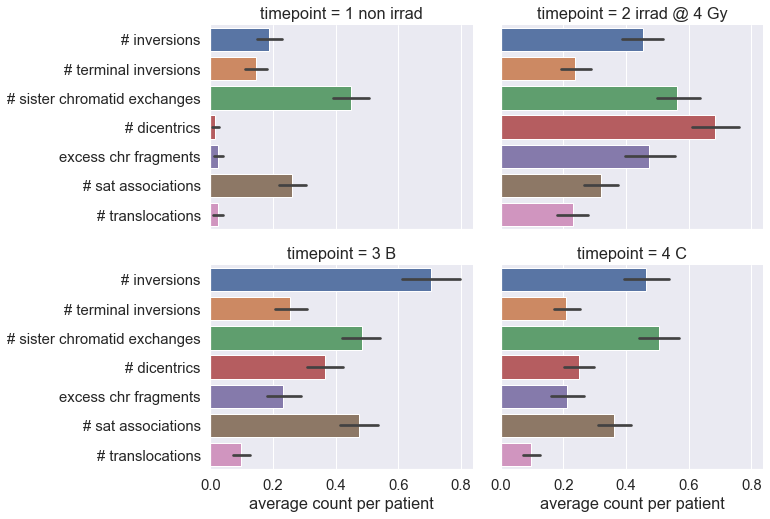

In [30]:
ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
ax = sns.set(font_scale=1.35)
ax = sns.catplot(y='aberration type', x='count per cell',
                 col='timepoint', col_wrap=2,  
                 data=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'], 
                 kind='bar', height=3.75, aspect=1.5, orient="h",)

ax.set_ylabels('')
ax.set_xlabels('average count per patient')

# ax.savefig('../graphs/chromosome aberr/all patients rearrangements.png', dpi=400)

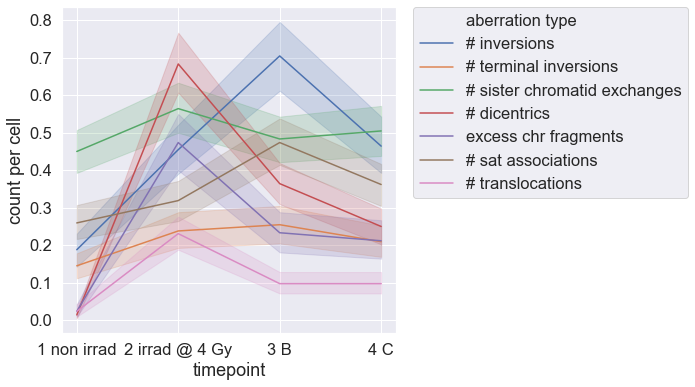

In [31]:
plt.figure(figsize=(6,6))
ax=sns.set(font_scale=1.5)
ax = sns.lineplot(x='timepoint', y='count per cell', data=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                  hue='aberration type', 
#                   palette=sns.color_palette("terrain", melt_aberrations['aberration type'].nunique()),
                  )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## Statistics Chromosome Rearrangements

In [32]:
trp.chr_scipy_anova_post_hoc_tests(df=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                                   post_hoc='tukeyHSD')

# inversions 8.463178205140987e-22
      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.2667   0.1365  0.3969  True 
 1 non irrad        3 B        0.5167   0.3865  0.6469  True 
 1 non irrad        4 C        0.2762   0.146   0.4064  True 
2 irrad @ 4 Gy      3 B         0.25    0.1198  0.3802  True 
2 irrad @ 4 Gy      4 C        0.0095  -0.1207  0.1397 False 
     3 B            4 C       -0.2405  -0.3707 -0.1103  True 
-------------------------------------------------------------


# terminal inversions 0.0025119885979506588
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower  upper  reject
------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.0929   0.0127 0.173   True 
 1 non irrad        3 B        0.1095   0.0294 0.1896  

In [33]:
# pivoting out aberrations for linear regression

group_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()
pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values='# inversions')

In [34]:
row = []
aberr_types = [col for col in group_chr.columns if col != 'patient id' and col != 'timepoint']

for aberr in aberr_types:
    pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values=aberr)
    x_name2 = ['1 non irrad']
    x_name3 = ['2 irrad @ 4 Gy', '1 non irrad']
    y_name = '4 C'

#     print(f'ABERRATION TYPE | {aberr}')
    for x_name in [x_name2, x_name3]:
        x = pivot_chr[x_name].values.reshape(-1, len(x_name))
        y = pivot_chr['4 C'].values.reshape(-1, 1)

        regression = LinearRegression().fit(x, y)
#         print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
#         print('\n')
        row.append(['Linear Regression', aberr, x_name, y_name, f'{regression.score(x, y):.4f}'])
    
LM_aberr_r2 = pd.DataFrame(data=row, columns=['Model', 'Aberration type', 'Variables', 'Target', 'R2 score'])

In [35]:
LM_aberr_r2

,Model,Aberration type,Variables,Target,R2 score
0,Linear Regression,# inversions,[1 non irrad],4 C,0.2348
1,Linear Regression,# inversions,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.2875
2,Linear Regression,# terminal inversions,[1 non irrad],4 C,0.0002
3,Linear Regression,# terminal inversions,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.0020
4,Linear Regression,# sister chromatid exchanges,[1 non irrad],4 C,0.4492
5,Linear Regression,# sister chromatid exchanges,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.5054
6,Linear Regression,# dicentrics,[1 non irrad],4 C,0.0000
7,Linear Regression,# dicentrics,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.5138
8,Linear Regression,excess chr fragments,[1 non irrad],4 C,0.0904
9,Linear Regression,excess chr fragments,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.1771


# Merge Telomere Length by TeloFISH & qPCR with Chromosome Aberrations from dGH

In [36]:
group_cleaned_chr_abber_df = group_chr[group_chr['timepoint'] != '2 irrad @ 4 Gy']
all_qPCR_chr_aberr = all_qPCR_df.merge(group_chr, on=['patient id', 'timepoint'])

df = (all_patients_df[all_patients_df['timepoint'] != '2 irrad @ 4 Gy']
      [['patient id', 'timepoint', 'telo means', 'Q1', 'Q2-3', 'Q4']])

all_merge = all_qPCR_chr_aberr.merge(df, on=['patient id', 'timepoint'])

In [37]:
all_merge.corr()

,patient id,telo means qPCR,SEM,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations,telo means,Q1,Q2-3,Q4
patient id,1.000000,-0.727371,-0.274298,0.028363,0.098589,-0.663084,-0.116706,-0.120282,-0.262275,0.290432,-0.103807,-0.462299,0.079277,-0.228650,0.057960
telo means qPCR,-0.727371,1.000000,0.496472,-0.070538,-0.149533,0.567774,-0.016668,0.048083,0.007022,-0.328996,-0.077618,0.393114,-0.111205,0.267469,-0.054226
SEM,-0.274298,0.496472,1.000000,-0.159086,-0.089996,0.042752,-0.268538,-0.243959,-0.054022,-0.140112,-0.139271,0.182625,0.012111,0.127554,-0.073739
# inversions,0.028363,-0.070538,-0.159086,1.000000,0.507592,0.039416,0.833096,0.720784,0.630637,-0.192776,0.547644,0.121941,-0.179119,-0.332343,0.300583
# terminal inversions,0.098589,-0.149533,-0.089996,0.507592,1.000000,0.063008,0.448356,0.377576,0.289249,-0.055367,0.231698,-0.012494,-0.217142,-0.384351,0.354966
# sister chromatid exchanges,-0.663084,0.567774,0.042752,0.039416,0.063008,1.000000,0.122808,0.252332,0.264843,-0.147548,0.044061,0.338439,-0.127603,0.180065,0.002254
# dicentrics,-0.116706,-0.016668,-0.268538,0.833096,0.448356,0.122808,1.000000,0.746255,0.510109,-0.243493,0.619436,0.255790,-0.148669,-0.480602,0.353566
excess chr fragments,-0.120282,0.048083,-0.243959,0.720784,0.377576,0.252332,0.746255,1.000000,0.434505,-0.139473,0.600181,0.183183,-0.284509,-0.325255,0.374440
# sat associations,-0.262275,0.007022,-0.054022,0.630637,0.289249,0.264843,0.510109,0.434505,1.000000,-0.003654,0.518489,0.282730,-0.183212,-0.218097,0.245518
# terminal SCEs,0.290432,-0.328996,-0.140112,-0.192776,-0.055367,-0.147548,-0.243493,-0.139473,-0.003654,1.000000,-0.169591,-0.060600,0.075603,0.076753,-0.094581


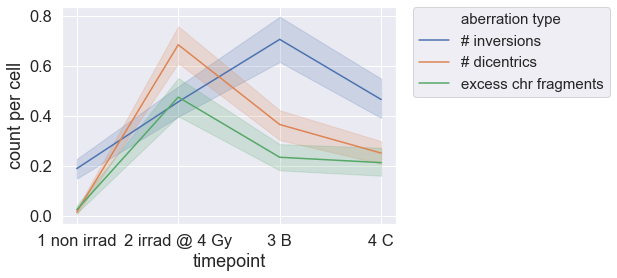

In [38]:
sns.lineplot(x='timepoint', y='count per cell', hue='aberration type', 
             data=melt_aberrations[melt_aberrations['aberration type'].isin(['# inversions', '# dicentrics', 'excess chr fragments'])])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')